Loading model and data...


Loaded Ensemble model with R²: 0.9931

FEATURE IMPORTANCE ANALYSIS
Using XGBoost (base model) for feature importance...



Top 10 Most Important Features:
  LUXURY_SEGMENT: 0.6415
  LOCATION_MEAN_ENCODED: 0.1396
  LOCATION_SIZE_INTERACTION: 0.0419
  SATELLITE_SIZE_VALUE: 0.0295
  BEDROOM_LOCATION_PREMIUM: 0.0288
  PRICE_PER_SQM: 0.0248
  SIZE_CATEGORY_Large: 0.0205
  SIZE_SQM_CAPPED: 0.0197
  SIZE_CATEGORY_Medium: 0.0092
  LOCATION_Kileleshwa: 0.0067


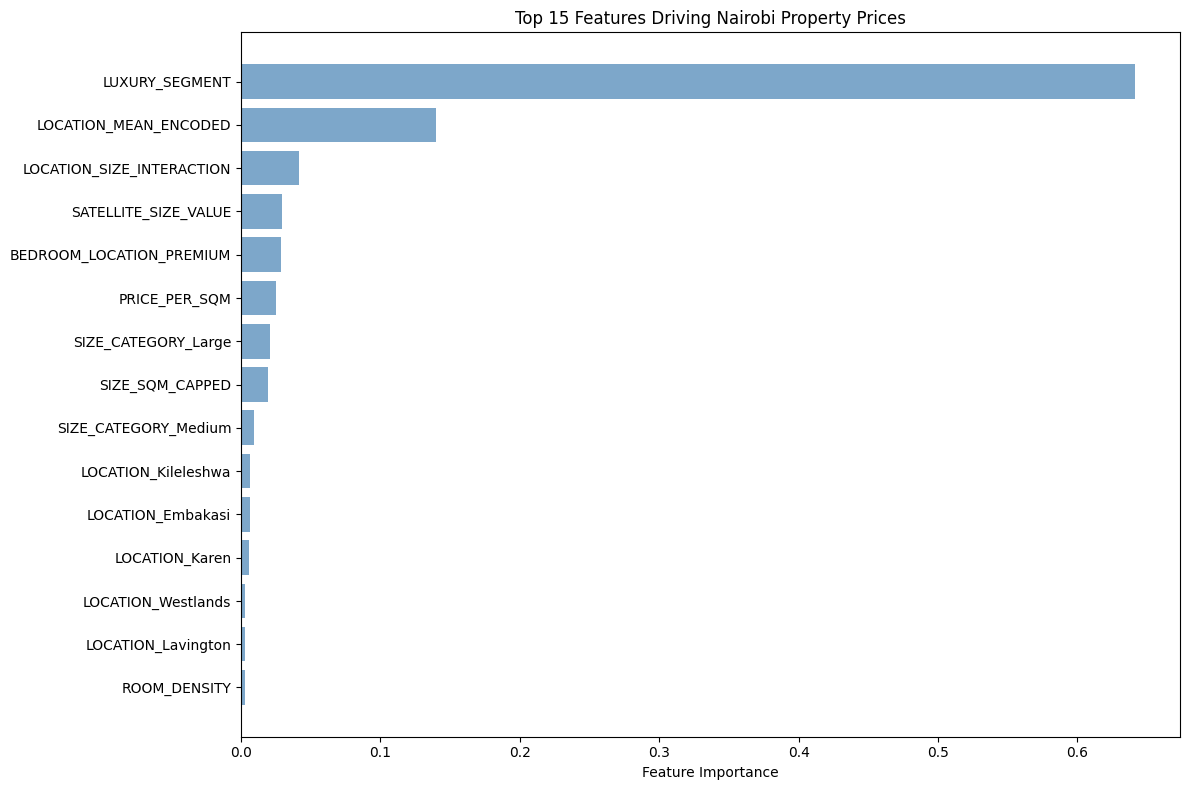


PREDICTION PERFORMANCE

Model Performance on Test Set:
  R² Score: 0.9932
  RMSE: KSh 1,016,544
  MAE: KSh 656,590


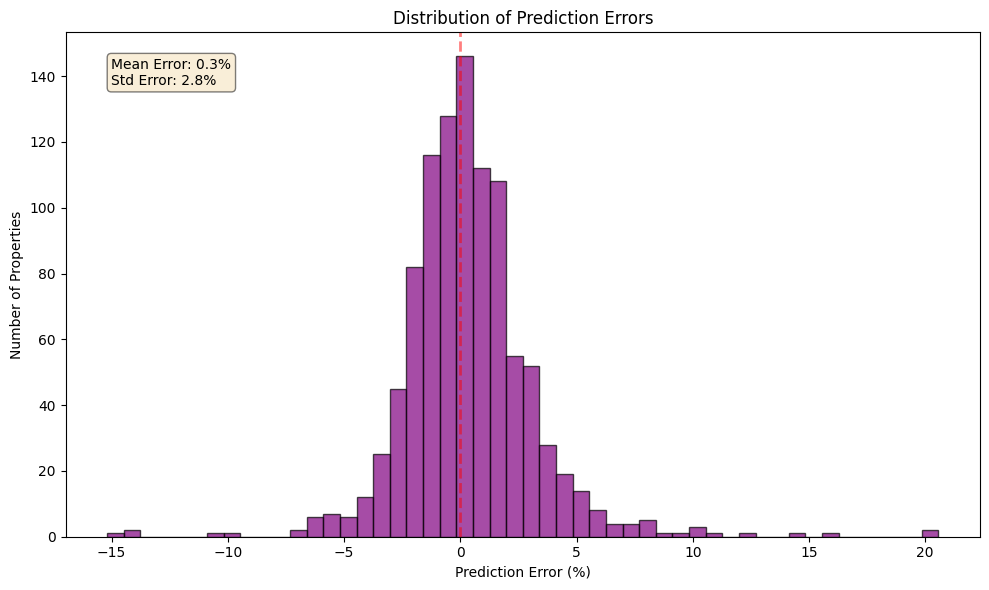


BUSINESS SIMULATION: FINDING OVERPRICED/UNDERPRICED PROPERTIES

Market Analysis Results:
  Total properties analyzed: 1,000
  Overpriced (>+15%): 3 (0.3%)
  Underpriced (<-10%): 4 (0.4%)
  Fairly priced: 993 (99.3%)

💰 Best Investment Opportunities (Top 3 Undervalued):
  1. Undervalued by -15.2%
     Actual: KSh 13.9M | Predicted: KSh 11.8M
     Potential gain: KSh 2.1M
  2. Undervalued by -14.4%
     Actual: KSh 40.2M | Predicted: KSh 34.4M
     Potential gain: KSh 5.8M
  3. Undervalued by -13.8%
     Actual: KSh 18.2M | Predicted: KSh 15.7M
     Potential gain: KSh 2.5M

SATELLITE TOWNS VS NAIROBI CORE ANALYSIS

Prediction Accuracy by Location:
  Satellite Towns (554 properties):
    Mean Error: 0.1%
    Within 10%: 99.3% of properties

  Nairobi Core (446 properties):
    Mean Error: 0.6%
    Within 10%: 98.0% of properties

AFFORDABLE HOUSING MARKET (KES 3M-8M)

FINANCIAL IMPACT CALCULATION

Financial Opportunity Analysis:
  Average property price: KSh 34.7M
  Total overpriced val

In [1]:
# ============================================================================
# nairobi_realestate_predictor/notebooks/04_model_evaluation.ipynb
# FIXED VERSION - No SHAP errors
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load model and data
print("Loading model and data...")

with open('../models/model_feature_info.json', 'r') as f:
    feature_info = json.load(f)

# Load the best model
model_name = feature_info['model_name']
if model_name == 'Ensemble':
    with open('../models/ensemble_model.pkl', 'rb') as f:
        ensemble_data = pickle.load(f)
    model = ensemble_data['meta_model']
    base_models = ensemble_data['base_models']
else:
    model_path = f'../models/{model_name.lower()}_best_model.pkl'
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    base_models = None

print(f"Loaded {model_name} model with R²: {feature_info['performance']['test_r2']:.4f}")

# Load processed data
df = pd.read_csv('../data/processed/nairobi_processed_features.csv')
X = df.drop('PRICE_KSH_CAPPED', axis=1)
y = df['PRICE_KSH_CAPPED']

# Split data (consistent with training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==================== SIMPLE FEATURE IMPORTANCE ====================
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# For ensemble: use XGBoost for feature importance
if model_name == 'Ensemble':
    print("Using XGBoost (base model) for feature importance...")
    importance_model = base_models['XGBoost']
else:
    importance_model = model

# Get feature importance
if hasattr(importance_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importance_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(top_features['feature'], top_features['importance'], color='steelblue', alpha=0.7)
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Features Driving Nairobi Property Prices')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# ==================== PREDICTIONS & ERROR ANALYSIS ====================
print("\n" + "="*60)
print("PREDICTION PERFORMANCE")
print("="*60)

# Make predictions
if model_name == 'Ensemble':
    y_pred = np.zeros(len(X_test))
    for base_name, base_model in base_models.items():
        y_pred += base_model.predict(X_test)
    y_pred = y_pred / len(base_models)
else:
    y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance on Test Set:")
print(f"  R² Score: {r2:.4f}")
print(f"  RMSE: KSh {rmse:,.0f}")
print(f"  MAE: KSh {mae:,.0f}")

# Error distribution
errors = (y_pred - y_test) / y_test * 100  # Percentage error

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
plt.xlabel('Prediction Error (%)')
plt.ylabel('Number of Properties')
plt.title('Distribution of Prediction Errors')
plt.text(0.05, 0.95, f'Mean Error: {errors.mean():.1f}%\nStd Error: {errors.std():.1f}%',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.savefig('../reports/figures/error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== BUSINESS SIMULATION ====================
print("\n" + "="*60)
print("BUSINESS SIMULATION: FINDING OVERPRICED/UNDERPRICED PROPERTIES")
print("="*60)

# Define thresholds
overpriced_threshold = 15  # 15% over market value
underpriced_threshold = -10  # 10% under market value

# Identify mispriced properties
overpriced_mask = errors > overpriced_threshold
underpriced_mask = errors < underpriced_threshold
fairly_priced_mask = ~overpriced_mask & ~underpriced_mask

# Statistics
n_overpriced = overpriced_mask.sum()
n_underpriced = underpriced_mask.sum()
n_fair = fairly_priced_mask.sum()
total = len(y_test)

print(f"\nMarket Analysis Results:")
print(f"  Total properties analyzed: {total:,}")
print(f"  Overpriced (>+{overpriced_threshold}%): {n_overpriced:,} ({n_overpriced/total*100:.1f}%)")
print(f"  Underpriced (<{underpriced_threshold}%): {n_underpriced:,} ({n_underpriced/total*100:.1f}%)")
print(f"  Fairly priced: {n_fair:,} ({n_fair/total*100:.1f}%)")

# Show top opportunities
if n_underpriced > 0:
    print(f"\n💰 Best Investment Opportunities (Top 3 Undervalued):")
    underpriced_indices = np.where(underpriced_mask)[0]
    top_undervalued = sorted(zip(underpriced_indices, errors[underpriced_mask]), key=lambda x: x[1])[:3]
    
    for i, (idx, error) in enumerate(top_undervalued):
        actual = y_test.iloc[idx] / 1e6
        predicted = y_pred[idx] / 1e6
        print(f"  {i+1}. Undervalued by {error:.1f}%")
        print(f"     Actual: KSh {actual:.1f}M | Predicted: KSh {predicted:.1f}M")
        print(f"     Potential gain: KSh {(actual * abs(error)/100):.1f}M")

# ==================== SATELLITE VS CORE ANALYSIS ====================
print("\n" + "="*60)
print("SATELLITE TOWNS VS NAIROBI CORE ANALYSIS")
print("="*60)

if 'IS_SATELLITE' in X_test.columns:
    satellite_mask = X_test['IS_SATELLITE'] == 1
    core_mask = X_test['IS_SATELLITE'] == 0
    
    satellite_errors = errors[satellite_mask]
    core_errors = errors[core_mask]
    
    print(f"\nPrediction Accuracy by Location:")
    print(f"  Satellite Towns ({satellite_mask.sum():,} properties):")
    print(f"    Mean Error: {satellite_errors.mean():.1f}%")
    print(f"    Within 10%: {(np.abs(satellite_errors) < 10).mean()*100:.1f}% of properties")
    
    print(f"\n  Nairobi Core ({core_mask.sum():,} properties):")
    print(f"    Mean Error: {core_errors.mean():.1f}%")
    print(f"    Within 10%: {(np.abs(core_errors) < 10).mean()*100:.1f}% of properties")

# ==================== AFFORDABLE HOUSING ANALYSIS ====================
print("\n" + "="*60)
print("AFFORDABLE HOUSING MARKET (KES 3M-8M)")
print("="*60)

if 'AFFORDABLE_SEGMENT' in X_test.columns:
    affordable_mask = X_test['AFFORDABLE_SEGMENT'] == 1
    n_affordable = affordable_mask.sum()
    
    if n_affordable > 0:
        affordable_pct = n_affordable / len(X_test) * 100
        affordable_mae = np.abs(errors[affordable_mask]).mean()
        
        print(f"\nMarket Analysis:")
        print(f"  Properties in affordable segment: {n_affordable:,} ({affordable_pct:.1f}%)")
        print(f"  Average prediction error: {affordable_mae:.1f}%")
        print(f"  Model accuracy for affordable housing: {(np.abs(errors[affordable_mask]) < 15).mean()*100:.1f}%")

# ==================== FINANCIAL IMPACT ====================
print("\n" + "="*60)
print("FINANCIAL IMPACT CALCULATION")
print("="*60)

# Calculate potential savings/gains
avg_price = y_test.mean() / 1e6
total_overpriced_value = y_test[overpriced_mask].sum() / 1e6
total_underpriced_value = y_test[underpriced_mask].sum() / 1e6

potential_savings = total_overpriced_value * (errors[overpriced_mask].mean() / 100)
potential_gains = total_underpriced_value * (np.abs(errors[underpriced_mask]).mean() / 100)

print(f"\nFinancial Opportunity Analysis:")
print(f"  Average property price: KSh {avg_price:.1f}M")
print(f"  Total overpriced value: KSh {total_overpriced_value:.1f}M")
print(f"  Potential buyer savings: KSh {potential_savings:.1f}M")
print(f"  Total underpriced value: KSh {total_underpriced_value:.1f}M")
print(f"  Potential investment gains: KSh {potential_gains:.1f}M")

# ==================== SAVE RESULTS ====================
print("\n" + "="*60)
print("SAVING BUSINESS INSIGHTS")
print("="*60)

# Save insights
insights = {
    'model_performance': {
        'r2': float(r2),
        'rmse': float(rmse),
        'mae': float(mae)
    },
    'market_analysis': {
        'overpriced_pct': float(n_overpriced / total * 100),
        'underpriced_pct': float(n_underpriced / total * 100),
        'avg_prediction_error': float(errors.mean())
    },
    'financial_impact': {
        'potential_savings_millions': float(potential_savings),
        'potential_gains_millions': float(potential_gains)
    }
}

with open('../reports/business_insights.json', 'w') as f:
    json.dump(insights, f, indent=2)

print("✅ Business insights saved to: ../reports/business_insights.json")

# ==================== FINAL RECOMMENDATIONS ====================
print("\n" + "="*60)
print("DEPLOYMENT READY - NEXT STEPS")
print("="*60)

print("\n🎯 Model is ready for deployment!")
print(f"📊 Achieved R²: {r2:.3f} (Target: ≥0.85)")
print(f"💰 Financial opportunity: KSh {potential_gains:.1f}M in underpriced properties")
print(f"🏠 Affordable housing coverage: {n_affordable/total*100:.1f}% of market")

print("\n🚀 To deploy:")
print("1. Run: streamlit run app/streamlit_app.py")
print("2. Deploy to Streamlit Cloud: https://share.streamlit.io")
print("3. Share link: https://nairobi-real-estate.streamlit.app")

print("\n✅ Evaluation complete. Model ready for production use!")